# Data exploration

Data exploration of ADNI patients. The data consists of features derived from T1 weighted images of patients in their first MRI visit in each phase of the program. The features were extracted using SIENAX to determine tissue types and FIRST to determine subcortical structure volumes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Data merging

In [2]:
df_features = pd.read_table('../DATA/processed_data_adni3.tsv', sep=' ').dropna()

# Combine left and right structures to single structure
structures = ['Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens']
for s in structures:
    df_features[s] = df_features['L_%s'%s]+df_features['R_%s'%s]
    
df_patient_list = pd.read_table('../DATA/participants_adni3.tsv', names=['Subject', 'PTID'])
df_metadata = pd.read_csv('../DATA/adni3_mri.csv', index_col=0)
df_full = df_patient_list.merge(df_features, on='Subject').merge(df_metadata, on='PTID')
                                                                 
# Remove sites that do not contain alzeihmers patient
df_full = df_full[df_full['SITEID'].isin([33, 55]) == False]

# Mark features to use
features = ['Brain_norm', 'GM_norm', 'WM_norm',
       'vscf_norm', 'pgrey_norm', 'Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens', 'Brainstem']
# Get back non-normalized (raw features)
for f in features[:5]:
    df_full[f] = df_full[f]/df_full['Vscale']

# Change gender assigment
df_full['PTGENDER'].replace(['Female','Male'],[0,1],inplace=True)

### Analysis on control

In [3]:
# Exctract controls
df_controls = df_full[df_full['DIAGNOSIS']==1.0]

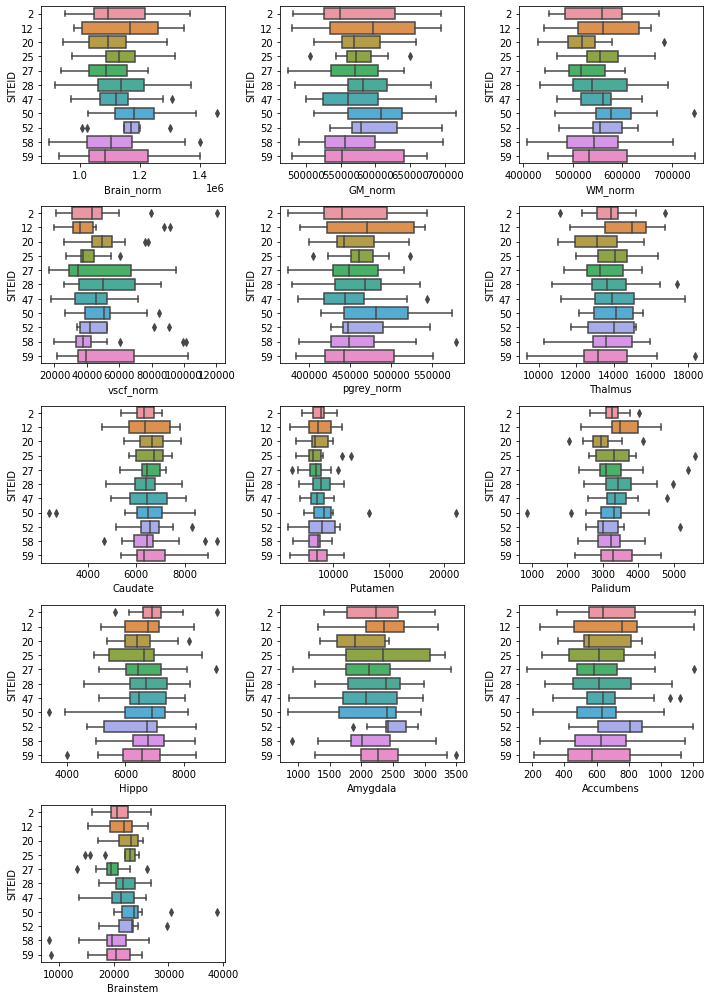

In [4]:
# Explor variability of features by site
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_controls, orient='h')
    plt.tight_layout()

In [5]:
# Data harmonization with Combat
from pycombat import Combat
combat = Combat()
Y = df_controls[features].to_numpy()
b = df_controls['SITEID'].to_numpy()
X = df_controls['AGE'].to_numpy()[:, np.newaxis]
C = df_controls[['Vscale', 'PTGENDER']].to_numpy()
y_adjusted = combat.fit_transform(Y=Y, b=b, X=X, C=C)

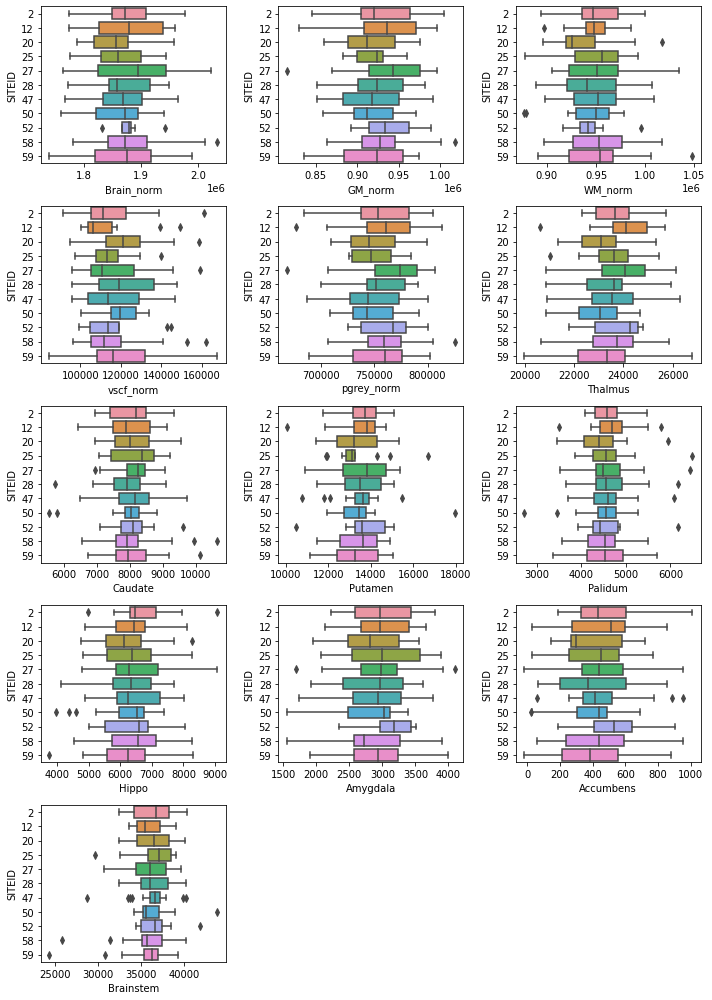

In [6]:
# Explor variability of features by site after harmonization
df_features_harm = pd.DataFrame(data=y_adjusted, columns=features)
df_features_harm['SITEID'] = df_controls['SITEID'].reset_index(drop=True)
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_features_harm, orient='h')
    plt.tight_layout()

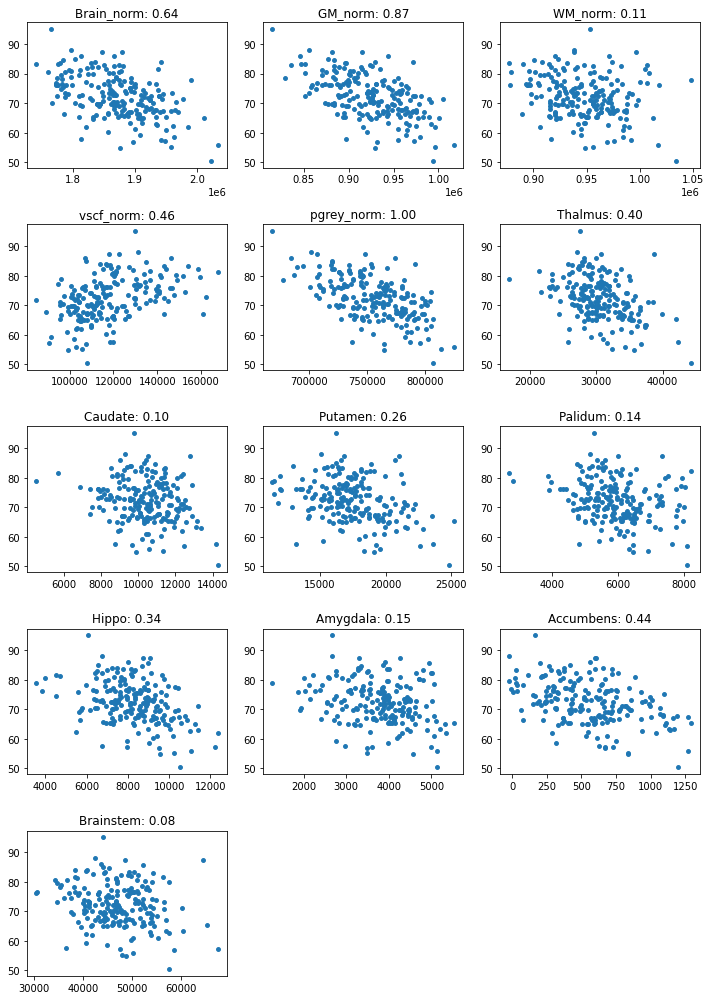

In [7]:
from sklearn.feature_selection import f_regression

X = df_features_harm[features].to_numpy()
Y = df_controls['AGE'].to_numpy()
# Normalize subcortical features by size of brain
vscale = df_controls['Vscale'].to_numpy()
X[:, 5:] = X[:, 5:]*vscale[:, None]

f_test, _ = f_regression(X, Y)
f_test /= np.max(f_test) # We normalize beacuse we are interested in relative values

plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X[:,d],Y,s=15)
    plt.title("{0}: {1:.2f}".format(features[d],f_test[d]))
plt.tight_layout()

In [8]:
# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train_norm = transformer.transform(X_train) # transform() normalizes
X_test_norm =  transformer.transform(X_test)

MAE in test: 3.972625


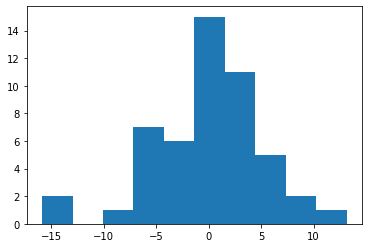

In [9]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression(fit_intercept='True')
# Train the model
LR.fit(X_train, Y_train)

# Compute the predictions over test data
f_test = LR.predict(X_test)
errors = Y_test-f_test
MAE_test = np.mean(np.abs(errors))
print('MAE in test: %f' % MAE_test)

plt.hist(errors)
plt.show()

### TODO

Create cross validation skeam y mirar lasso, ridge, y polynomial
Combinar datos de ADNI2 y ADNI3 mirar variabilidad 

### Brain delta in MCI and AD

Brain delta mean for
CN: -0.051237
MCI: 1.863735
AD: 5.765088
Brain delta median for
CN: 0.143248
MCI: 1.852814
AD: 5.218324


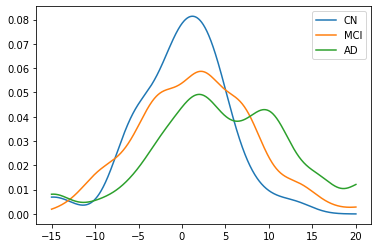

In [10]:
# Obtain dataframes for each diagnosis
df_mci = df_full[df_full['DIAGNOSIS']==2.0]
df_ad = df_full[df_full['DIAGNOSIS']==3.0]

# Set data for processing
X_mci = df_mci[features].to_numpy()
Y_mci = df_mci['AGE'].to_numpy()
b_mci = df_mci['SITEID'].to_numpy()
C_mci = df_mci[['Vscale', 'PTGENDER']].to_numpy()
X_ad = df_ad[features].to_numpy()
Y_ad = df_ad['AGE'].to_numpy()
b_ad = df_ad['SITEID'].to_numpy()
C_ad = df_ad[['Vscale', 'PTGENDER']].to_numpy()

# Harmonize
X_mci_harm = combat.transform(Y=X_mci, b=b_mci, X=Y_mci[:, np.newaxis], C=C_mci)
X_ad_harm = combat.transform(Y=X_ad, b=b_ad, X=Y_ad[:, np.newaxis], C=C_ad)

# Make estimations
delta_brain_controls = errors
delta_brain_mci = LR.predict(X_mci_harm)-Y_mci
delta_brain_ad = LR.predict(X_ad_harm)-Y_ad

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_brain_controls))
print('MCI: %f' % np.mean(delta_brain_mci))
print('AD: %f' % np.mean(delta_brain_ad))
print('Brain delta median for')
print('CN: %f' % np.median(delta_brain_controls))
print('MCI: %f' % np.median(delta_brain_mci))
print('AD: %f' % np.median(delta_brain_ad))

# Plot kernel density estimates for samples
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(-15, 20, 1000)[:, np.newaxis]
kde_cn = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_controls[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='AD')
plt.legend()
plt.show()

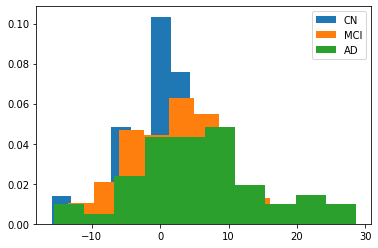

In [11]:
plt.hist(delta_brain_controls, label='CN', density=True)
plt.hist(delta_brain_mci, label='MCI', density=True)
plt.hist(delta_brain_ad, label='AD', density=True)
plt.legend()
plt.show()

In [12]:
# TODO mirar conversor donde cae